In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Concatenate, Input, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd

# 데이터 로드 및 전처리

In [3]:

news_data = pd.read_csv('/content/drive/My Drive/result_0916.csv')

news_data=news_data.rename(columns={"small_category":'category'})
news_data=news_data.dropna(axis=0)
news_data.reset_index(drop=True, inplace=True)
news_data

,link,title,date,content,tag,big_category,category
0,http://it.chosun.com/site/data/html_dir/2020/0...,"한컴위드·네이버, '사설인증 사업 협력'을 위한 업무협약 체결",2020.09.15,"[<div class=""par"">투명 디스플레이 제조업체 레온이 일본 나리타국제공항...","레온,투명디스플레이,초박형,나리타공항,이온몰",기업,반도체·디스플레이
1,http://it.chosun.com/site/data/html_dir/2020/0...,"[기자방담] 자동차 배출가스 규제안, 이대로 괜찮나?",2020.09.15,"[<div class=""par"">한글과컴퓨터그룹<span style=""font-si...","한컴위드,한글과컴퓨터,네이버,한컴패스,애니핀,사설인증사업",기업,컴퓨팅·IT서비스
2,http://it.chosun.com/site/data/html_dir/2020/0...,"""뒷차 램프 특이하면 현대차일 것""",2020.09.15,"[<div class=""par"">크라우드 펀딩 플랫폼 와디즈가 건강 먹거리를 선보일...","와디즈,한국야쿠르트,푸드스타트업,스타트업,스타트프레시업,인큐베이팅",기업,중기·벤처
3,http://it.chosun.com/site/data/html_dir/2020/0...,"넷킬러, 구글 드라이브 문서 외부 공유 탐지 솔루션 선봬",2020.09.15,"[<div class=""par"">""투싼은 현대차 SUV 중에서도 가장 중요한 차라고...","자동차,국산차,현대자동차,투싼,신형투싼,투싼디자인,이상엽",자동차,일반
4,http://it.chosun.com/site/data/html_dir/2020/0...,[게임브리핑] '겜밍아웃'하고 청소년 돕는 '아이머게이머 챌린지' 진행 외 (9월 ...,2020.09.15,"[<div class=""par"">구글 클라우드 솔루션 전문기업 넷킬러가 구글 지스위...","넷킬러,구글지스위트,넷킬러dlp,문서공유,외부링크공유,문서보안,문서현황파악,기밀유출...",기업,컴퓨팅·IT서비스
...,...,...,...,...,...,...,...
12414,http://it.chosun.com/site/data/html_dir/2019/0...,"니콘, 35mm 미러리스 Z7&Z6; 가이드북 출간",2019.03.07,"[<div class=""par"">카카오게임즈는 사이게임즈에서 개발한 모바일 애니메이...","카카오게임즈,모바일게임,프린세스",게임·라이프,게임·인터넷
12415,http://it.chosun.com/site/data/html_dir/2019/0...,"KB국민은행, 1680억원 규모 미국 가스발전소 PF 공동주선",2019.03.07,"[<div class=""par"">니콘이미징코리아는 7일 35㎜ 미러리스 Z시리즈를 ...","니콘이미징코리아,35mm,z7,z6,미러리스,가이드북,이벤트,캐시백",기업,PC·가전·모바일
12416,http://it.chosun.com/site/data/html_dir/2019/0...,닌텐도 스위치로 가상현실 게임 즐겨요…'라보(Labo) VR 키트' 4월 발매,2019.03.07,"[<div class=""par"">KB국민은행은 1억5000만달러(약 1680억원) ...","IT조선, itchosun, IT조선, 금융·핀테크",기업,금융·핀테크
12417,http://it.chosun.com/site/data/html_dir/2019/0...,모바일 MMORPG ‘마스터탱커’ 3월 11일 정식서비스 확정,2019.03.07,"[<div class=""par"">한국닌텐도는 오는 4월 12일 ‘닌텐도 라보(Nin...","한국닌텐도,라보,vr,닌텐도스위치",게임·라이프,게임·인터넷


In [4]:
news_data['big_category'].unique()

array(['기업', '자동차', '게임·라이프', '기술', '사람', '전체 기사', '뉴스', '칼럼·해설'],
      dtype=object)


================================================

<기술>
- 공통 --> 일반
- 기술 --> 과학·기술 , 보안 , 로봇·드론·VR

=================================================

<게임·라이프>
- 문화/예술 --> 미디어·엔터테인먼트, 게임·인터넷
- 사회 --> 유통·쇼핑, 키덜트·키즈, 일반

=======================================================

<기업>
- 일반, 중기·벤처, 산업일반, 중공업 제거

- 공통 --> 컴퓨팅·IT서비스, 방송·통신, 외신
- 경제 --> 금융·핀테크
- 건강 --> 헬스케어·바이오
- 기술 --> PC·가전·모바일, 반도체·디스플레이


In [5]:
tech=news_data[news_data['big_category'] == '기술'].index ################# 기술
news_data.iloc[tech].category.unique()  # '과학·기술', '일반', '로봇·드론·VR', '보안'

game_life=news_data[news_data['big_category'] == '게임·라이프'].index
news_data.iloc[game_life].category.unique() #'미디어·엔터테인먼트', '게임·인터넷', '유통·쇼핑', '일반', '키덜트·키즈'

company=news_data[news_data['big_category'] == '기업'].index 
news_data.iloc[company].category.unique() #'일반', '컴퓨팅·IT서비스', 'PC·가전·모바일', '금융·핀테크', '중기·벤처', '반도체·디스플레이', '헬스케어·바이오', '외신', '방송·통신', '산업일반', '중공업'


array(['반도체·디스플레이', '컴퓨팅·IT서비스', '중기·벤처', '금융·핀테크', '방송·통신', 'PC·가전·모바일',
       '외신', '헬스케어·바이오', '중공업', '일반', '산업일반'], dtype=object)


카테고리 삭제

In [6]:
news_data['category'].value_counts()

drop1=news_data[news_data['big_category'] == '자동차'].index
news_data=news_data.drop(drop1)
drop2=news_data[news_data['big_category'] == '칼럼·해설'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '사람'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '전체 기사'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '뉴스'].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중기·벤처')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='산업일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중공업')].index
news_data=news_data.drop(drop2)


news_data.reset_index(drop=True, inplace=True)

팀메이트에 맞는 카테고리로 변환 --> 교육이 없음ㅠㅠ

In [7]:
import numpy as np

news_data['team_category'] = np.nan
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='과학·기술')].index]='기술'

news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='보안')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='로봇·드론·VR')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='일반')].index]= '공통'

news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='미디어·엔터테인먼트')].index]= '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='게임·인터넷')].index] = '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='유통·쇼핑')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='키덜트·키즈')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='일반')].index] = '사회'

news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='컴퓨팅·IT서비스')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='방송·통신')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='외신')].index]= '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='금융·핀테크')].index] = '경제'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='헬스케어·바이오')].index]= '건강'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='PC·가전·모바일')].index]= '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='반도체·디스플레이')].index] = '기술'



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
news_data.isna().sum()
news_data['team_category']

0          기술
1          공통
2          공통
3       문화/예술
4          경제
        ...  
9127    문화/예술
9128       기술
9129       경제
9130    문화/예술
9131    문화/예술
Name: team_category, Length: 9132, dtype: object

In [9]:
# 카테고리 정수 인코딩

category_list = pd.factorize(news_data['team_category'])[1]
news_data['category'] = pd.factorize(news_data['team_category'])[0]

news_data['category'].unique()
category_list.nunique()

news_data=news_data[['title','content','tag','category']]

In [10]:
news_data['category'].value_counts() # 6개의 카테고리

1    2814
0    2179
2    1721
3     970
4     962
5     486
Name: category, dtype: int64

# 뉴스 제목, 기사 내용, 태그 내용 전처리

In [11]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
news_data['title'] = news_data['title'].str.replace("[^\w]", " ")

In [12]:
#  기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거, 기호 제거 후 띄어쓰기로 분리 준비

import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

news_data['regex_content'] = ''
news_data['regex_blank'] = ''

for n in range(len(news_data['content'])):
  sub_content= re.sub(p,'',news_data['content'][n]) #html 구조 제거한 기사 문장
  news_data['regex_blank'][n]= p2.findall(news_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  news_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [13]:
#태그 전처리

news_data['tag_1'] = ''

for i in range(len(news_data['tag'])) :
  news_data['tag_1'][i]= news_data['tag'][i].replace(',',' ')

  # .replace(',',' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
news_data['regex_content'][0]

' 투명 디스플레이 제조업체 레온이 일본 나리타국제공항에 자체 개발한 초박형 투명 디스플레이를 설치했다고 15일 밝혔다   레온은 일본 최대 공항인 나리타국제공항에 가로 2m  세로 5m의 걸개형양면 투명 디스플레이를 설치했다  제1터미널과 제2터미널의 사우스윙  노스윙 출발 로비에 각 1개씩 총 4개를 설치했다  두께는  3㎝  무게는 1㎡당 3 4㎏다  천장에 걸개 형태로 늘어뜨려 부착했고  투명 양면 형태로 디스플레이 양쪽에 서로 다른 영상이 나온다  나리타 공항은 이를 통해 공항 이용자들에게 동영상 광고와 안내문을 표출하고 있다 레온은 2020년 초에도 나리타 국제공항 출입국 보안 검색대 유리 벽면에 투명 디스플레이를 설치했다  제1터미널 사우스윙  노스윙에 각 2개  제2터미널 중앙 출구에 6개 등 총 10개를 설치했다  이 디스플레이는 가로 3 5m  세로 40㎝ 유리 점착 형태로 설치됐다  일본어  한국어  영어  중국어 등 4개 언어로 공항 이용자들에게 동영상과 안내문을 보여준다 레온은 일본 최대 쇼핑몰인 이온몰 본점에도 가로 1m  세로 5m의 걸개형 디스플레이와  가로 12m  세로 1m의 배너형디스플레이를 각각 설치했다  걸개형태는 본사 1층 천장에서 늘어뜨리고  배너형태는 유리 펜스에 점착해 설치했다  이온몰에 설치된 레온의 투명 디스플레이는 일본 NHK를 비롯한 24개 방송 및 언론매체에 소개되기도 했다 일본 도쿄 하라주쿠 내 메이지신궁 앞에 위치한 JING 대형 쇼핑몰에도 레온의 가로 7m  세로 8m의 유리점착형 투명 디스플레이가 설치됐다 레온의 초박형 투명 디스플레이는 9년간 총 300억원을 들여 개발에 성공한 국산 기술이다  PCB가 필름 형태의 투명 모듈로 건물 유리창 안쪽에 붙여  설치하면 실내에서 외부 전경을 그대로 볼 수 있다  얇고 가벼워 건물이나 유리창에 무리를 주지 않고 설치할 수 있다  밝기도 실내용은 1500 2000니트   실외용은3000 5000니트에 달해 흐린 날은 물론 화창한 날에도 선명한 화질을 보여준다 

In [15]:
# 메캅 사용 X -> split으로 대체
########################################## ########################################## ########################################## 
# ######################                     MECAB 설치 https://sosomemo.tistory.com/31                     ###################### 
# ########################################## ########################################## ########################################## 

# !apt-get update
# !apt-get install g++ openjdk-8-jdk
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [16]:
news_data['headline']=news_data['title'] +' ' + news_data['tag_1'] + ' ' + news_data['regex_content']
news_data['headline']

# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기
stopwords = ['','또','함께','수','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']

X_token = []
for stc in news_data['headline']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)


In [17]:
len(X_token),len(news_data['category'])

(9132, 9132)

# test, trainset / classification fitting

In [18]:
from sklearn.model_selection import train_test_split

# split하면서 shuffle 적용
X_train, X_test, y_train, y_test = train_test_split(X_token, news_data['category'], test_size=0.2,shuffle=True)

# 카테고리 OnehotVector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

# y_train.nunique(), y_test.nunique()

6
6


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 헤드라인 정수인코딩
tokenizer = Tokenizer(150000) # 가장 빈도가 높은 150000개의 단어만 선택하도록 함
tokenizer.fit_on_texts(X_train) #vocabulary 만들기
X_train = tokenizer.texts_to_sequences(X_train) # vocabulary랑 매칭해 인덱스로 나타내기, 리스트 변환
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
print(len(tokenizer.word_index))

wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count <= 2:
        wc += 1

print(wc)

265264
194249


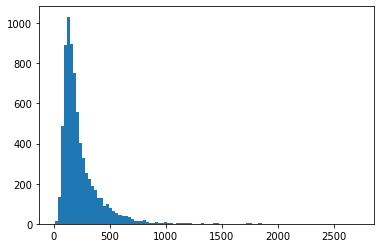

In [21]:
import matplotlib.pyplot as plt # 500단어

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
plt.show()

In [22]:
max_len = 500 # 헤드라인 문장 길이를 보고 맞춰주기 - 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [23]:
model = Sequential()
model.add(Embedding(150000, 256))
model.add(LSTM(256))
model.add(Dense(6, activation='softmax')) #출력개수 6개의 카테고리

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=300, epochs=10)

#batch_size : 한번의 batch마다 주는 데이터 샘플 사이즈/ 한 번에 모든 데이터를 넣을 수가 없음
#iteration 
# epoch : 전체 데이터 셋에 대해 한 번 학습을 완료한 상태

Epoch 1/10
25/25 [==============================] - 308s 12s/step - loss: 1.6424 - acc: 0.3235 - val_loss: 1.4782 - val_acc: 0.4083
Epoch 2/10
25/25 [==============================] - 306s 12s/step - loss: 1.1016 - acc: 0.6225 - val_loss: 1.2179 - val_acc: 0.6300
Epoch 3/10
25/25 [==============================] - 309s 12s/step - loss: 0.5229 - acc: 0.8465 - val_loss: 0.7164 - val_acc: 0.7657
Epoch 4/10
25/25 [==============================] - 306s 12s/step - loss: 0.1143 - acc: 0.9682 - val_loss: 0.6846 - val_acc: 0.7860
Epoch 5/10
25/25 [==============================] - 307s 12s/step - loss: 0.0289 - acc: 0.9941 - val_loss: 0.7330 - val_acc: 0.7739
Epoch 6/10
25/25 [==============================] - 304s 12s/step - loss: 0.0103 - acc: 0.9990 - val_loss: 0.7908 - val_acc: 0.7975
Epoch 7/10
25/25 [==============================] - 306s 12s/step - loss: 0.0043 - acc: 0.9992 - val_loss: 0.8148 - val_acc: 0.7947
Epoch 8/10
25/25 [==============================] - 304s 12s/step - loss: 0.

# AI타임즈 최근 뉴스120개 분류해보기

In [33]:
test_csv=pd.read_csv('/content/drive/My Drive/times_content.csv')
test_list =pd.read_csv('/content/drive/My Drive/AItimes_list.csv')

times_data= pd.merge(test_csv, test_list,on='link')
times_data = times_data[['tag','content','title']]

In [34]:
times_data

,tag,content,title
0,"엔비디아,ARM,소프트뱅크,GPU,CPU,반도체",[<p>결국 엔비디아가 ARM을 인수했다. 인수액은 400억달러(약 47조원). 전...,"엔비디아, ARM 인수 '확정'…젠슨 황, ""AI 시대를 위한 결정"""
1,NaN,[<p>광주와 전남지역을 합쳐 하나의 지방자치단체를 만들자는 '광주·전남 행정통합'...,광주·전남 행정 통합 논의 시동 걸었다
2,NaN,"[<p> </p>, <p>1조원의 예산이 투입되는 AI 중심 산업융합 집적단지가 광...",[Monday News] 'AI 중심도시 광주' 이것이 풀어야 할 과제다 ④ 광주 ...
3,"5G,전자파,전자기파,전파,무선통신,이동통신,과기정통부",[<p>국립전파연구원이 전자파에 대한 올바른 정보를 제공한다. 온라인 포럼을 통해 ...,"인체에 유해한 전자파?…국립전파연구원, '팩트체크' 자리 마련"
4,NaN,"[<p>삼성전기가 초소형 파워인덕터를 개발했다. </p>, <p>파워인덕터는 반도체...","삼성전기, 초소형 파워인덕터 개발…엣지 AI 소형화 가속"
...,...,...,...
115,"국립전파연구원,국제전기통신연합,ITU,ITU-T,SG17,양자암호통신,정보보호,국제...",[<p>국제표준기구가 국내 연구진 주도로 제안한 정보보호 분야 표준안 8건을 국제 ...,국내 주도 ICT 보안 표준안 8건 '국제 표준' 채택
116,NaN,[<p>4족 보행 로봇 ‘스폿(Spot)’이 코로나19 최전방에서 고생하는 의료진에...,"로봇견 ‘스폿’, 코로나19 최전방서 의료진 도와 활약할까"
117,"산업통상자원부,인공지능반도체,AI반도체,자율주행차,사물인터넷,IoT,바이오,로봇,미세공정",[<p>정부가 인공지능(AI) 반도체 상용화를 목표로 관련 기술 개발에 착수한다. ...,"산업부, AI 반도체 상용화 위한 기술 개발 추진… 미래차ㆍIoT 등에 적용한다"
118,"한국인공지능학회,인공지능,AI,인공지능대학원,AI대학원,바이오의료,신경과학,컴퓨터비전",[<p>한국인공지능학회(학회장 유창동)는 인공지능(AI) 연구자의 학술 교류 및 최...,"한국인공지능학회, '2020년 하계학술대회' 열어 AI 연구 조망"


In [35]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
times_data['title'] = times_data['title'].str.replace("[^\w]", " ")

# 기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거 후 띄어쓰기
import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

times_data['regex_content'] = ''
times_data['regex_blank'] = ''

for n in range(len(times_data['content'])):
  sub_content= re.sub(p,'',times_data['content'][n]) #html 구조 제거한 기사 문장
  times_data['regex_blank'][n]= p2.findall(times_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  times_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)

times_data['regex_content']

# 태그 내용 전처리

times_data['tag_1'] = ''
for i in range(len(times_data['tag'])) :
  if times_data['tag'].isnull()[i]: times_data['tag_1'][i] = ""
  else : times_data['tag_1'][i]= times_data['tag'][i].replace(',',' ')

  
times_data['headline']=times_data['title'] +' ' + times_data['tag_1'] + ' ' + times_data['regex_content']
times_data['headline']

0      엔비디아  ARM 인수  확정  젠슨 황   AI 시대를 위한 결정  엔비디아 AR...
1      광주 전남 행정 통합 논의 시동 걸었다   광주와 전남지역을 합쳐 하나의 지방자치단...
2       Monday News   AI 중심도시 광주  이것이 풀어야 할 과제다 ④ 광주 ...
3      인체에 유해한 전자파  국립전파연구원   팩트체크  자리 마련 5G 전자파 전자기파...
4      삼성전기  초소형 파워인덕터 개발 엣지 AI 소형화 가속   삼성전기가 초소형 파워...
                             ...                        
115    국내 주도 ICT 보안 표준안 8건  국제 표준  채택 국립전파연구원 국제전기통신연...
116    로봇견  스폿   코로나19 최전방서 의료진 도와 활약할까   4족 보행 로봇  스...
117    산업부  AI 반도체 상용화 위한 기술 개발 추진  미래차ㆍIoT 등에 적용한다 산...
118    한국인공지능학회   2020년 하계학술대회  열어 AI 연구 조망 한국인공지능학회 ...
119     턱스크 잡는다    LG U    AIㆍ5G 방역로봇  개발   마스크 착용 여부...
Name: headline, Length: 120, dtype: object

In [36]:
# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기

stopwords = ['','함께','하지만','뿐','한','또','수','결국','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']

X_token = []
for stc in times_data['headline']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)

In [37]:
# token_stc =m.nouns(sentence)
empty = []

for token_stc in X_token :
  encode_stc = tokenizer.texts_to_sequences([token_stc])
  pad_stc = pad_sequences(encode_stc, maxlen=500)
  score = model.predict(pad_stc)
  result_category = category_list[score.argmax()]
  result_prob= score[0, score.argmax()] # 확률값 반환
  empty.append([result_category, result_prob])

In [38]:
result=pd.DataFrame(empty,columns=['category','prob'])
resultttt=pd.concat([times_data,result],axis=1)

resultttt[['title','category','prob']]

,title,category,prob
0,엔비디아 ARM 인수 확정 젠슨 황 AI 시대를 위한 결정,공통,0.998753
1,광주 전남 행정 통합 논의 시동 걸었다,공통,0.998585
2,Monday News AI 중심도시 광주 이것이 풀어야 할 과제다 ④ 광주 ...,공통,0.999030
3,인체에 유해한 전자파 국립전파연구원 팩트체크 자리 마련,공통,0.998203
4,삼성전기 초소형 파워인덕터 개발 엣지 AI 소형화 가속,기술,0.994530
...,...,...,...
115,국내 주도 ICT 보안 표준안 8건 국제 표준 채택,기술,0.898705
116,로봇견 스폿 코로나19 최전방서 의료진 도와 활약할까,기술,0.837821
117,산업부 AI 반도체 상용화 위한 기술 개발 추진 미래차ㆍIoT 등에 적용한다,기술,0.897603
118,한국인공지능학회 2020년 하계학술대회 열어 AI 연구 조망,공통,0.637715


In [39]:
resultttt.category.value_counts()

공통       89
기술       18
경제        6
문화/예술     4
건강        3
Name: category, dtype: int64

In [46]:
resultttt[resultttt.category == '문화/예술'][['tag','headline','category','prob']].sort_values(['prob'],ascending=False)

,tag,headline,category,prob
41,"네이버,연세대학교,MOU,협약식,상호협약,SW,HW,온라인협약,교육과정공동개발",네이버 연세대학교 AI 인재 발굴 위한 협력 제휴 네이버 연세대학교 MOU 협약식...,문화/예술,0.838676
55,NaN,톰 행크스 짐 캐리 린제이 로한 거물급 스타들 총출동한 뮤비 공개 스파이더...,문화/예술,0.752111
46,NaN,VR 콘텐츠 진화 BCWW에서 확인한다 국내 가상현실 콘텐츠 진화는 어느 단계...,문화/예술,0.669944
28,NaN,기획 ①코로나 블루 시대 AI음악이 위로한다 안창욱 지스트 교수 인공지능 이...,문화/예술,0.584386
